# TODO

**Test the assumptions of Multiple OLS**:
* No multicolieaerity
* Normality of residuals.
* Linear relationship.
* Homoscedasticity.


**Convert timeseries to 5 minute intervals**

**Create forecasting function**
Moving window of training, and testing.

#### Local Imports

In [1]:
from src.data.base_dataset import BaseDataset
from src.data.train_test_generate import generate_rv_data, generate_intraday_data
import src.data.data_generators as dg

#### External Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


sns.set()

### Dataset

In [3]:
dataset = BaseDataset("./data/raw/eth_dataset.parquet")

In [4]:
dataset.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,,
2018-01-01 00:01:00,1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
2018-01-01 00:02:00,1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
2018-01-01 00:03:00,1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
2018-01-01 00:04:00,1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
2018-01-01 00:05:00,1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [5]:
df = dataset.dataframe

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1956200 entries, 2018-01-01 00:01:00 to 2021-09-21 00:00:00
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 164.2 MB


## Exploratory Data Analysis

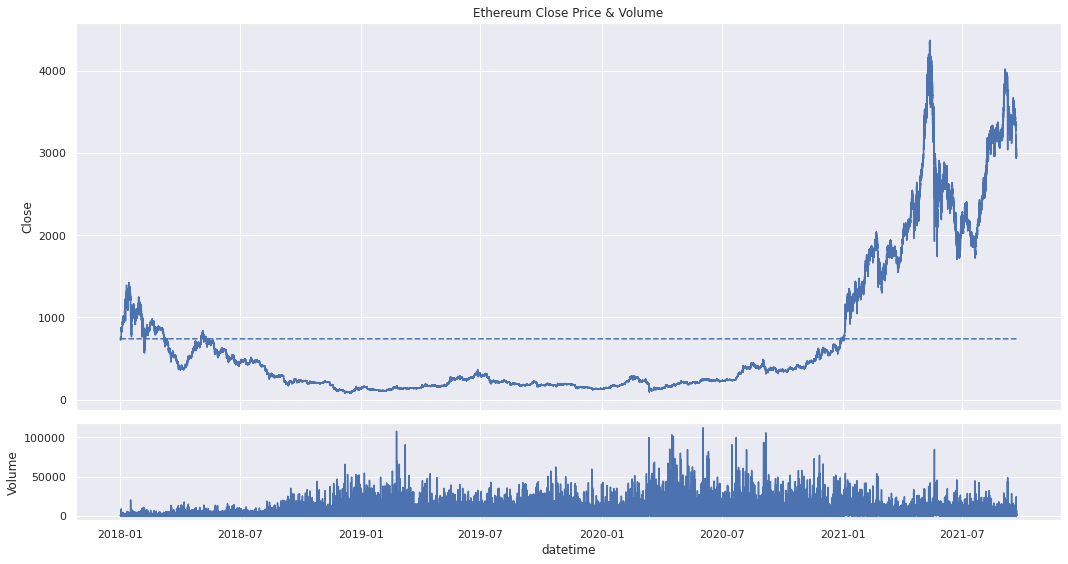

In [9]:
initial_price = np.full(len(df), df['Close'][0])
# specify plot layouts with different width using subplots()
f, axs = plt.subplots(2,1,
                      figsize=(15,8),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[2,0.5]))

# make scatterplot with legends
sns.lineplot(data=df,
                x="datetime", y="Close",
                ax=axs[0],
                color='b'
                ).set(title="Ethereum Close Price & Volume")
sns.lineplot(data=df,
                x='datetime',
                y=initial_price,
                ax=axs[0],
                linestyle='dashed',
                color='b')
sns.lineplot(data=df,
                x="datetime",
                y="Volume",
                ax=axs[1],
                legend=False,
                color='b')
f.tight_layout()

In [7]:
rv_1min = pd.DataFrame()
rv_1min["Daily"] = np.sqrt(dataset.realized_variance("Close", "daily"))
rv_1min["Weekly"] = rv_1min["Daily"].rolling(7).mean()
rv_1min["Monthly"] = rv_1min["Daily"].rolling(28).mean()
rv_1min = rv_1min.dropna()

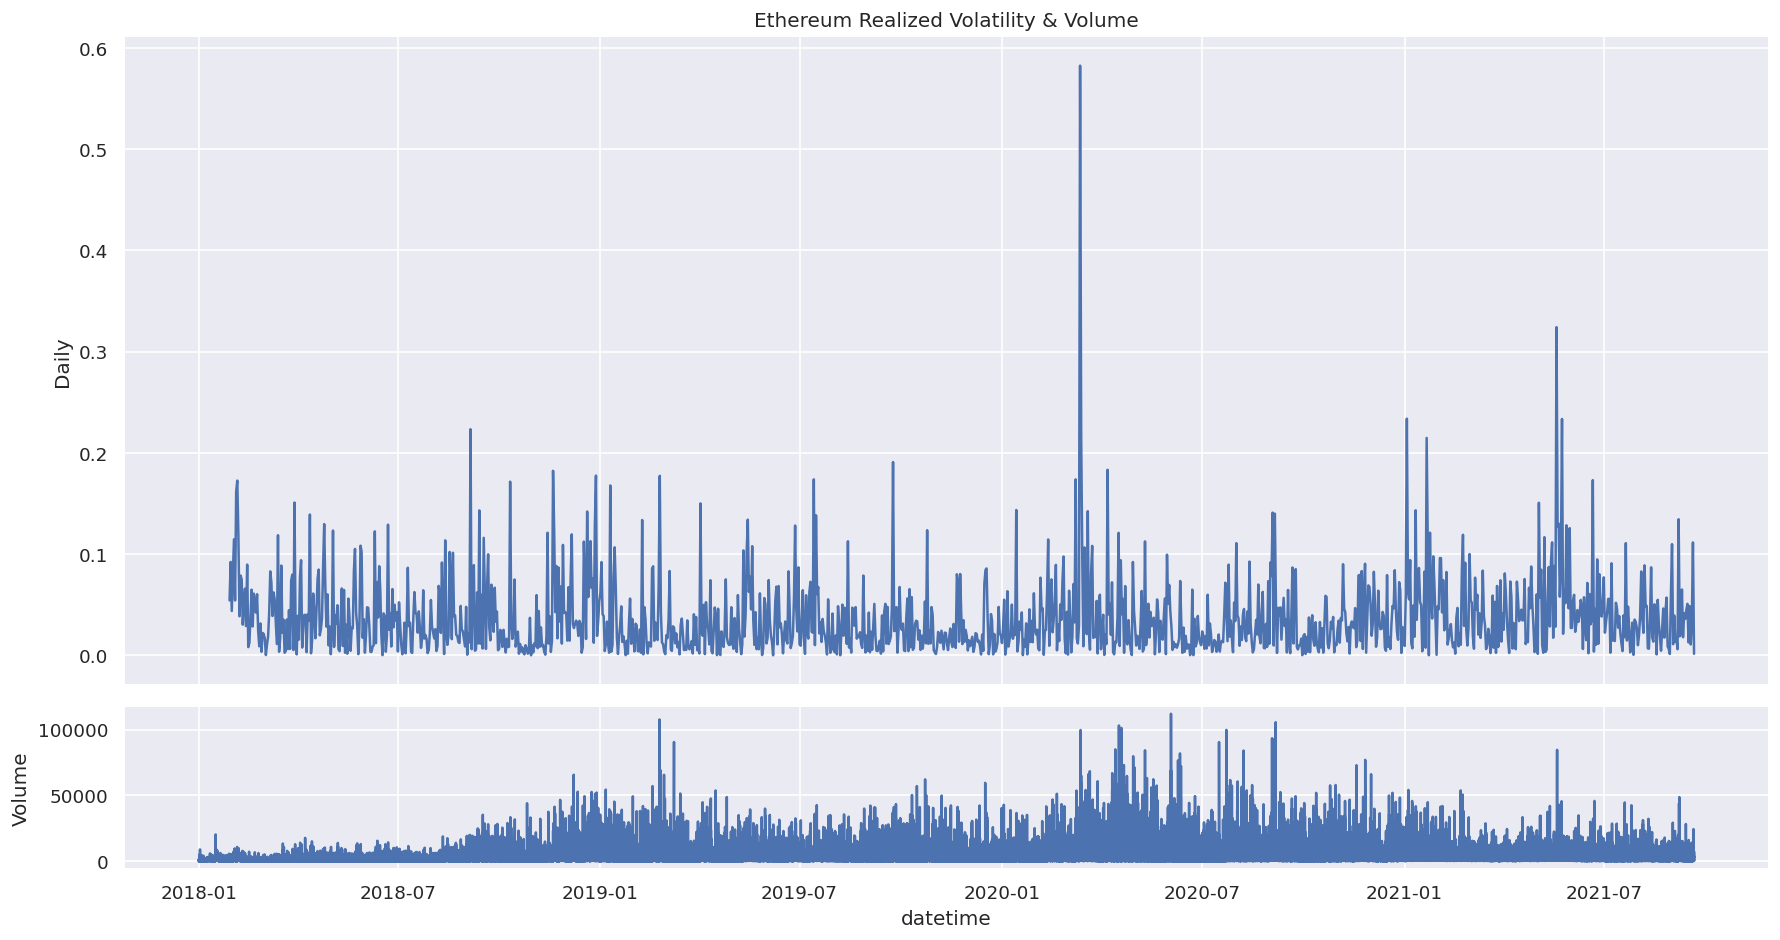

In [44]:
initial_price = np.full(len(rv_1min), df['Close'][0])
# specify plot layouts with different width using subplots()
f, axs = plt.subplots(2,1,
                      figsize=(15,8),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[2,0.5]))

# make scatterplot with legends
sns.lineplot(data=rv_1min,
                x="datetime", y="Daily",
                ax=axs[0],
                color='b'
                ).set(title="Ethereum Realized Volatility & Volume")
sns.lineplot(data=df,
                x="datetime",
                y="Volume",
                ax=axs[1],
                legend=False,
                color='b')
f.tight_layout()

In [8]:
rv_1min

,Daily,Weekly,Monthly
datetime,,,
2018-01-29,0.054305,0.046161,0.063110
2018-01-30,0.092306,0.057305,0.061766
2018-01-31,0.043813,0.052459,0.060247
2018-02-01,0.079271,0.062001,0.062902
2018-02-02,0.114659,0.078325,0.066273
...,...,...,...
2021-09-17,0.048655,0.036050,0.034903
2021-09-18,0.010739,0.035036,0.034623
2021-09-19,0.031773,0.033651,0.035595


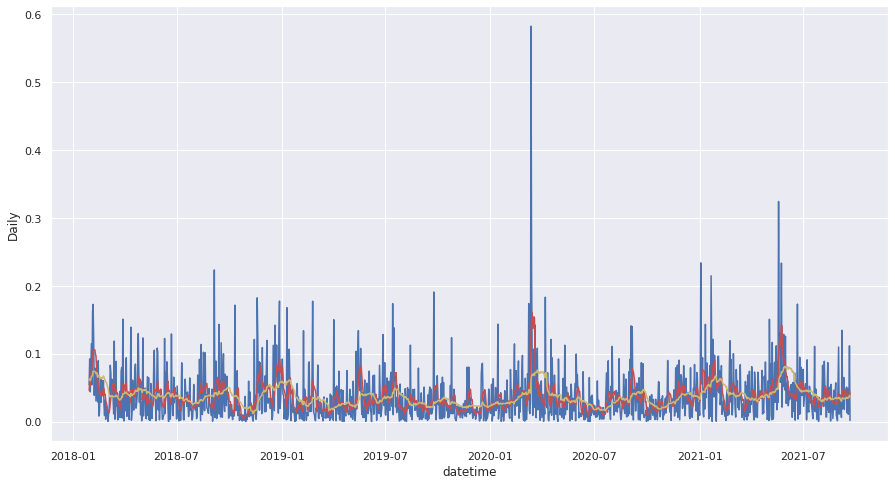

In [9]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=rv_1min, x="datetime", y="Daily", color="b")
sns.lineplot(data=rv_1min, x="datetime", y="Weekly", color="r")
sns.lineplot(data=rv_1min, x="datetime", y="Monthly", color="y")
plt.show()

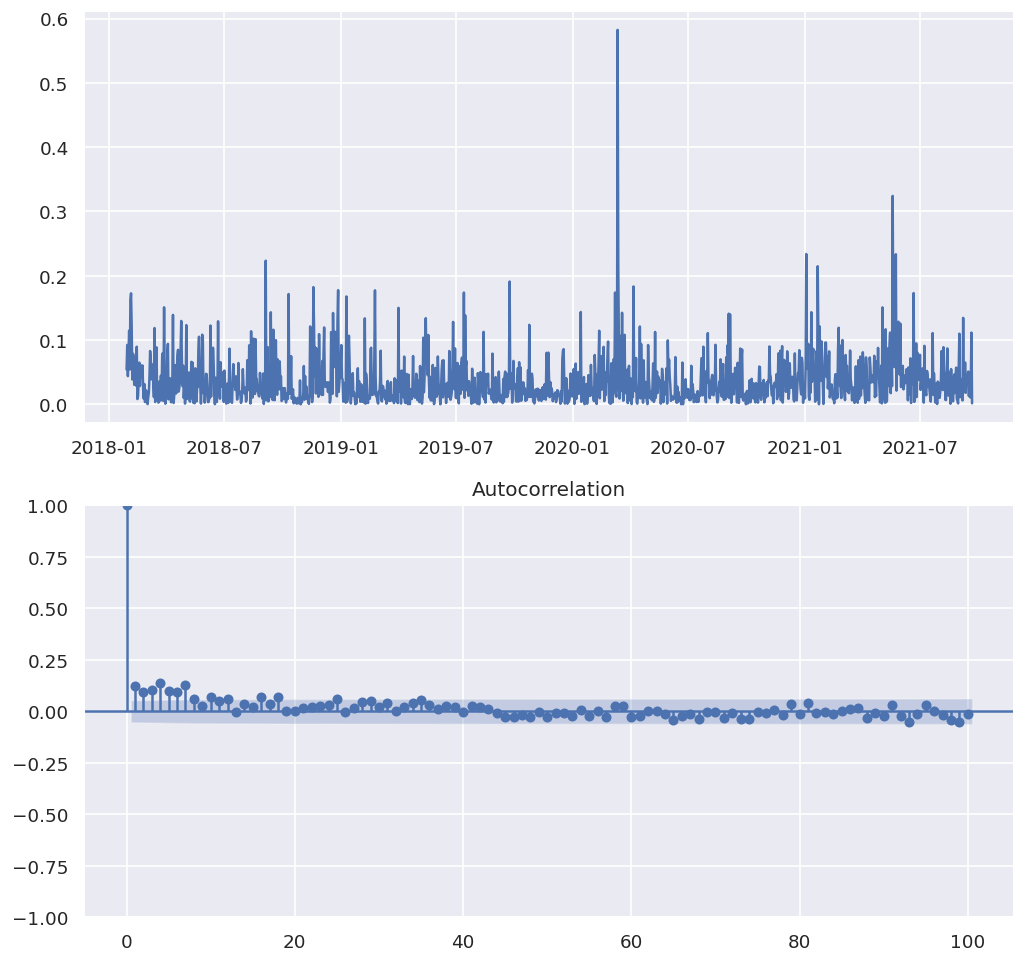

In [10]:
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2)
axes[0].plot(rv_1min["Daily"])
axes[1].set_title('Original Series')
plot_acf(rv_1min["Daily"], ax=axes[1], lags=100)

plt.show()

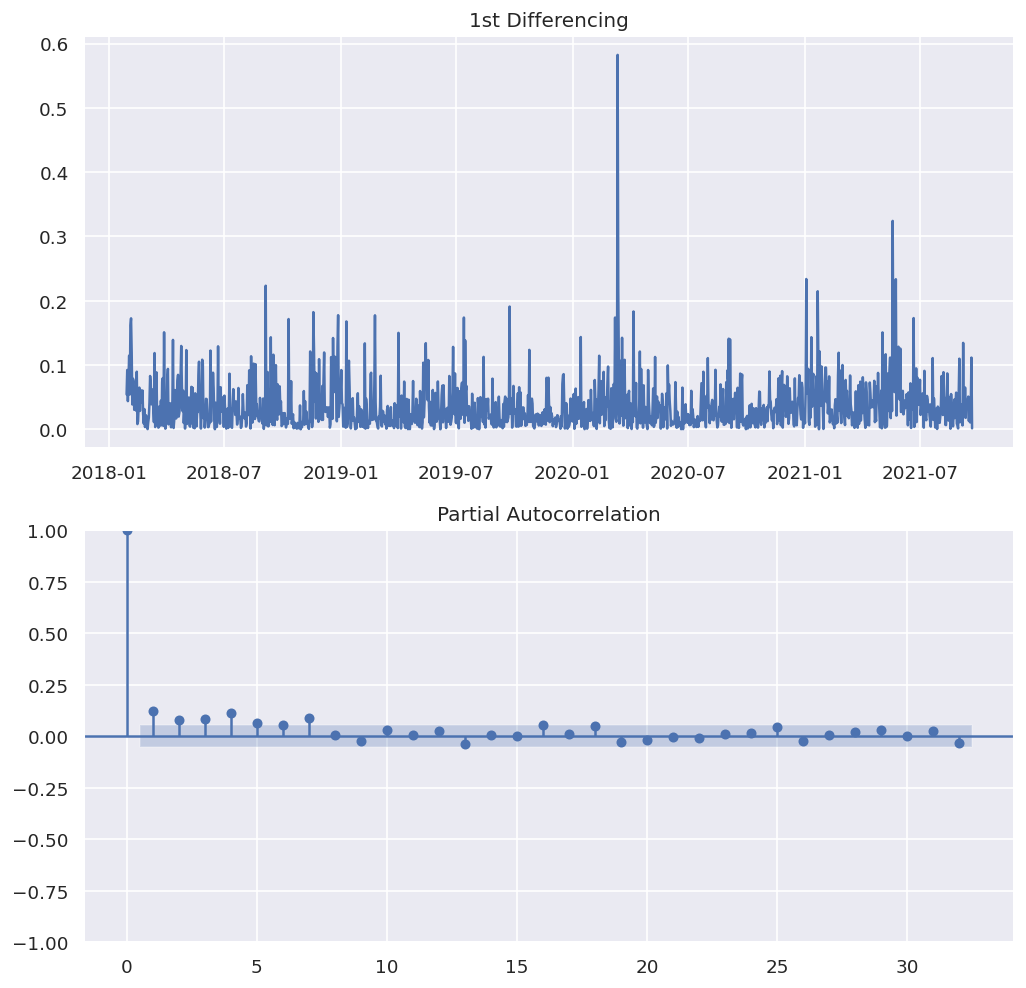

In [11]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(10, 10), 'figure.dpi':120})

fig, axes = plt.subplots(2)
axes[0].plot(rv_1min["Daily"]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(rv_1min["Daily"].dropna(), ax=axes[1], method="ywm")

plt.show()

## Assumptions

This section is devoted to testing the assumptions on the input data for linear regressions and multilevel linear regressions.

In [12]:
def variance(series):
    return np.sum(np.square(series - np.mean(series))) / series.shape[0]

[Text(0.5, 1.0, 'Ethereum Realized Volatility & Volume')]

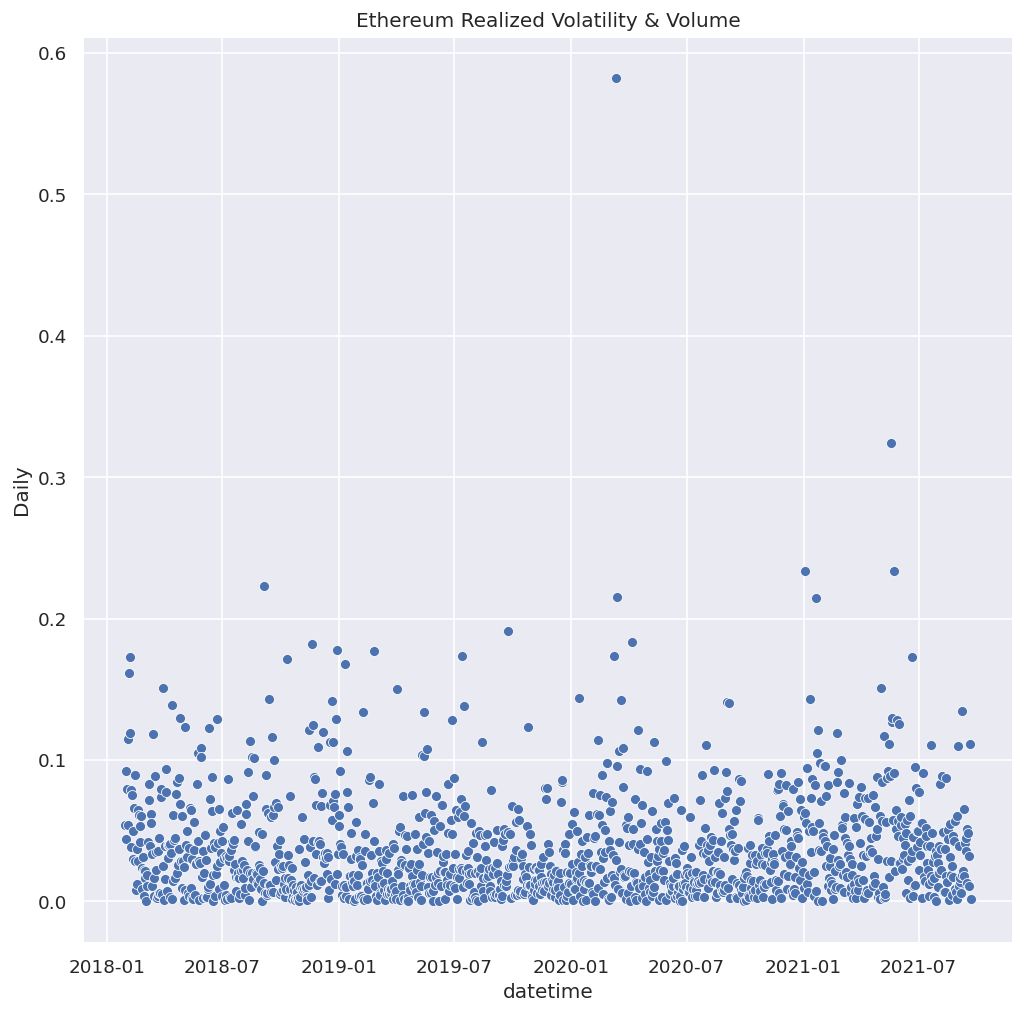

In [13]:
sns.scatterplot(x=rv_1min.index,
             y=rv_1min['Daily'],
             color='b'
             ).set(title="Ethereum Realized Volatility & Volume")

In [14]:
adf = adfuller(rv_1min["Daily"])
print(f"The test statistic of the Augmented Dickey-Fuller test is: {adf[0]}")
print(f"The p-value of the Augmented Dickey-Fuller test is: {adf[1]}")

The test statistic of the Augmented Dickey-Fuller test is: -9.883337087084996
The p-value of the Augmented Dickey-Fuller test is: 3.719681280151303e-17


## Modeling

### HAR

The Heterogeneous Autoregression model of Corsi (2009) is a simple and empirically useful specification for realized volatility.
It takes the form:

$$RV_t = \beta_0 + \beta_1 RV_{t-1} + \beta_2 RV_{t-1 |t-5} + \beta_3 RV_{t-1|t-22} + u_t$$
where $RV_{t-j|t-h} = \frac{1}{h}\sum_{i=j}^{h} RV_{t-i}$.

This model is developed on ordinary stock returns and thus the 5 day difference in $\beta_2$ is accounting for a trading week and the 22 day difference in $\beta_3$ is accounting for a trading month.
Since cryptocurrencies trade at all times, the periods are adapted to be 7 days and 28 days.

In [79]:
y = rv_1min['Daily'][1:].reset_index(drop=True)
X = rv_1min.iloc[:-1, :].reset_index(drop=True)
dates = y.index
X = sm.add_constant(X)

train_test_split = int(0.66 * X.shape[0])

X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]

In [80]:
X_train

,const,Daily,Weekly,Monthly
0,1.0,0.054305,0.046161,0.063110
1,1.0,0.092306,0.057305,0.061766
2,1.0,0.043813,0.052459,0.060247
3,1.0,0.079271,0.062001,0.062902
4,1.0,0.114659,0.078325,0.066273
...,...,...,...,...
873,1.0,0.000210,0.011170,0.025502
874,1.0,0.004000,0.007827,0.024424
875,1.0,0.064889,0.016595,0.025963
876,1.0,0.000186,0.013877,0.025417


In [81]:
y_train

0      0.092306
1      0.043813
2      0.079271
3      0.114659
4      0.054186
         ...   
873    0.004000
874    0.064889
875    0.000186
876    0.036102
877    0.008831
Name: Daily, Length: 878, dtype: float64

In [82]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     14.15
Date:                Sun, 08 May 2022   Prob (F-statistic):           5.22e-09
Time:                        16:43:08   Log-Likelihood:                 1600.2
No. Observations:                 878   AIC:                            -3192.
Df Residuals:                     874   BIC:                            -3173.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.004      4.002      0.000       0.008       0.024
Daily          0.0489      0.038      1.302      0.193      -0.025       0.123
Weekly         0.3108      0.095      3.287      0.001       0.125       0.496
Monthly        0.1779      0.133      1.334      0.182      -0.084       0.440
==============================================================================
Omnibus:                      859.493   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71192.407
Skew:                           4.249   Prob(JB):                         0.00
Kurtosis:                      46.288   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

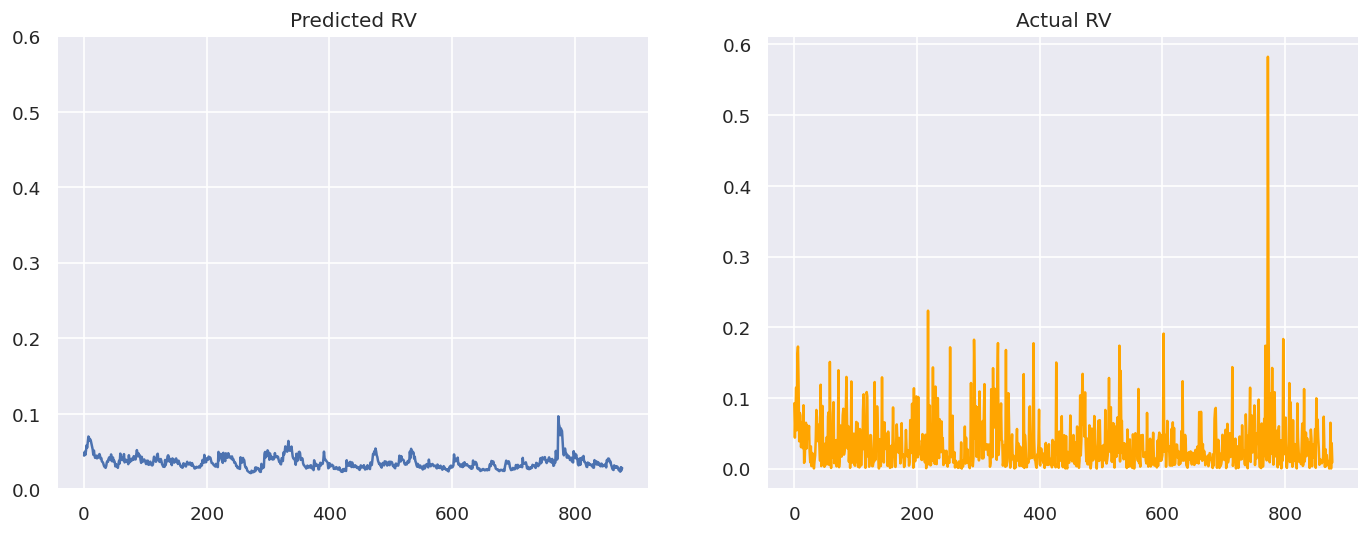

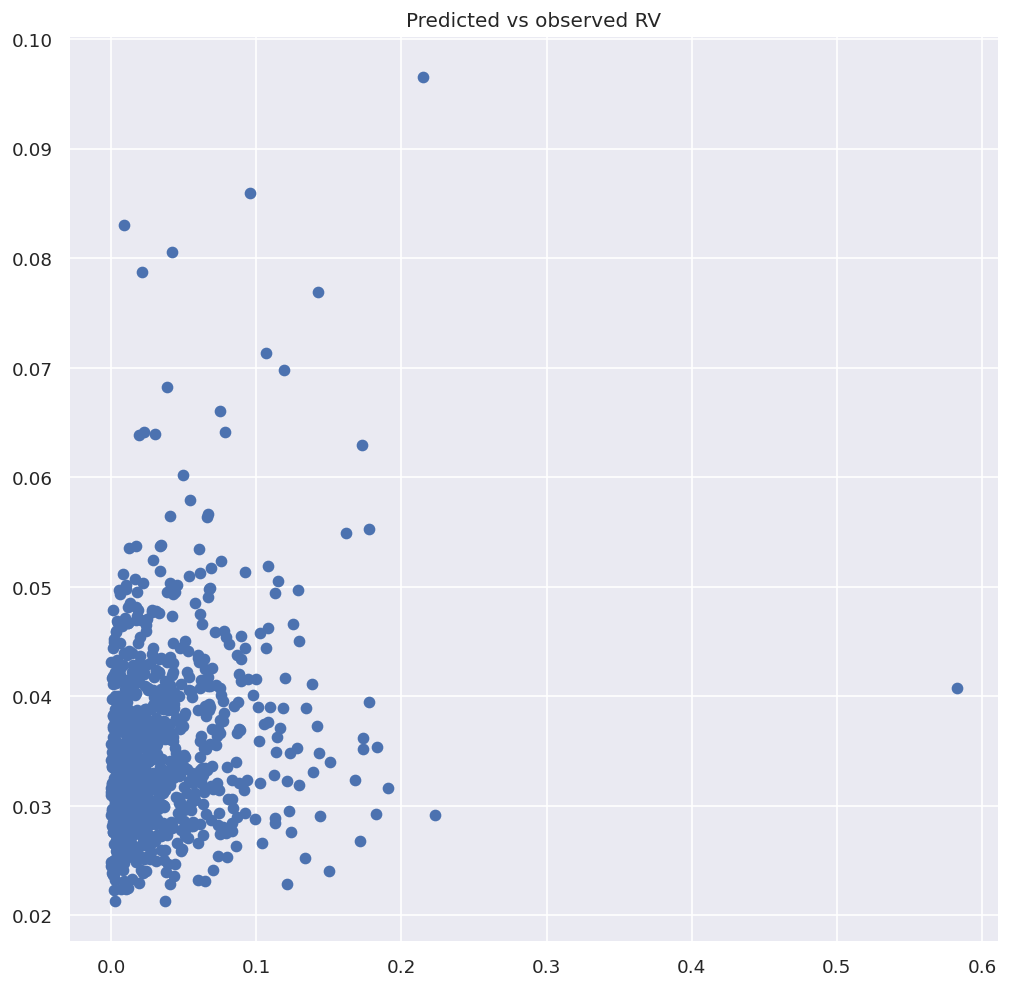

In [83]:

y_hat = results.predict(X_train)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train.index, y_train, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

<AxesSubplot:>

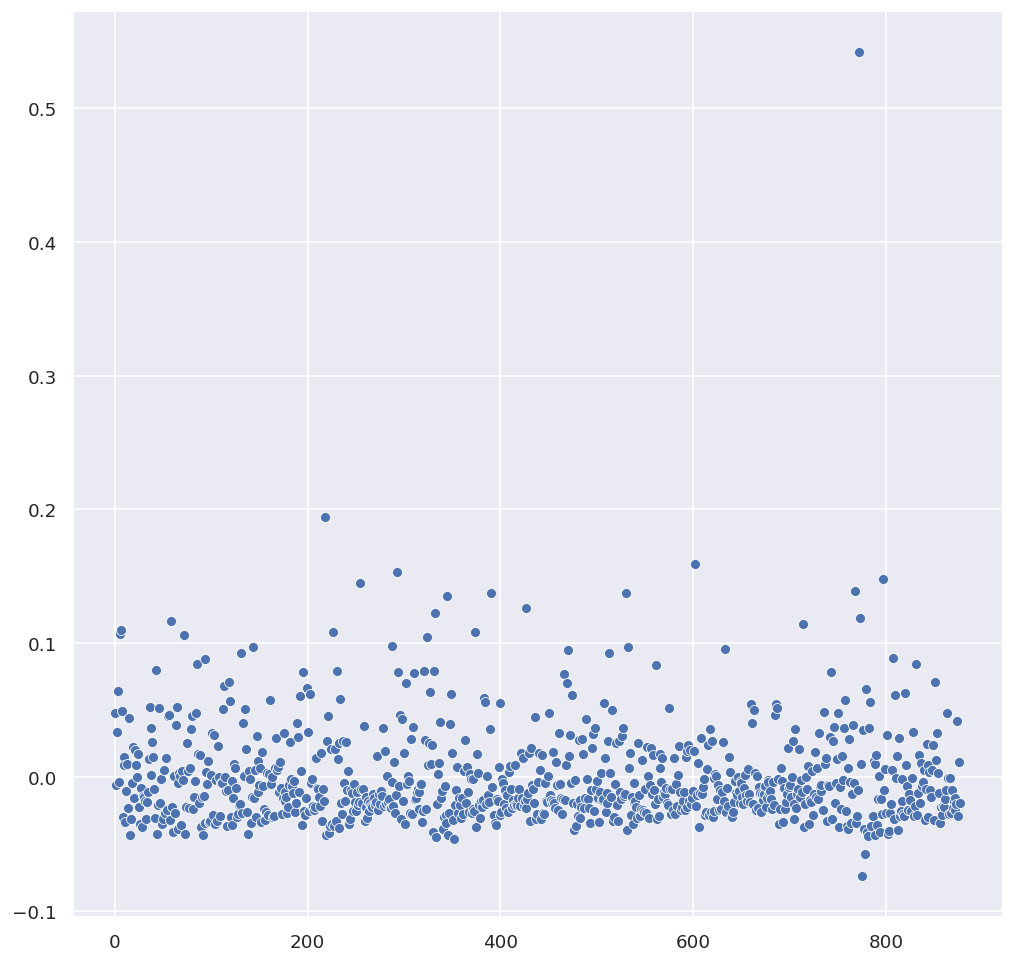

In [90]:
sns.scatterplot(x=results.resid.index, y=results.resid.values)

<AxesSubplot:xlabel='Daily'>

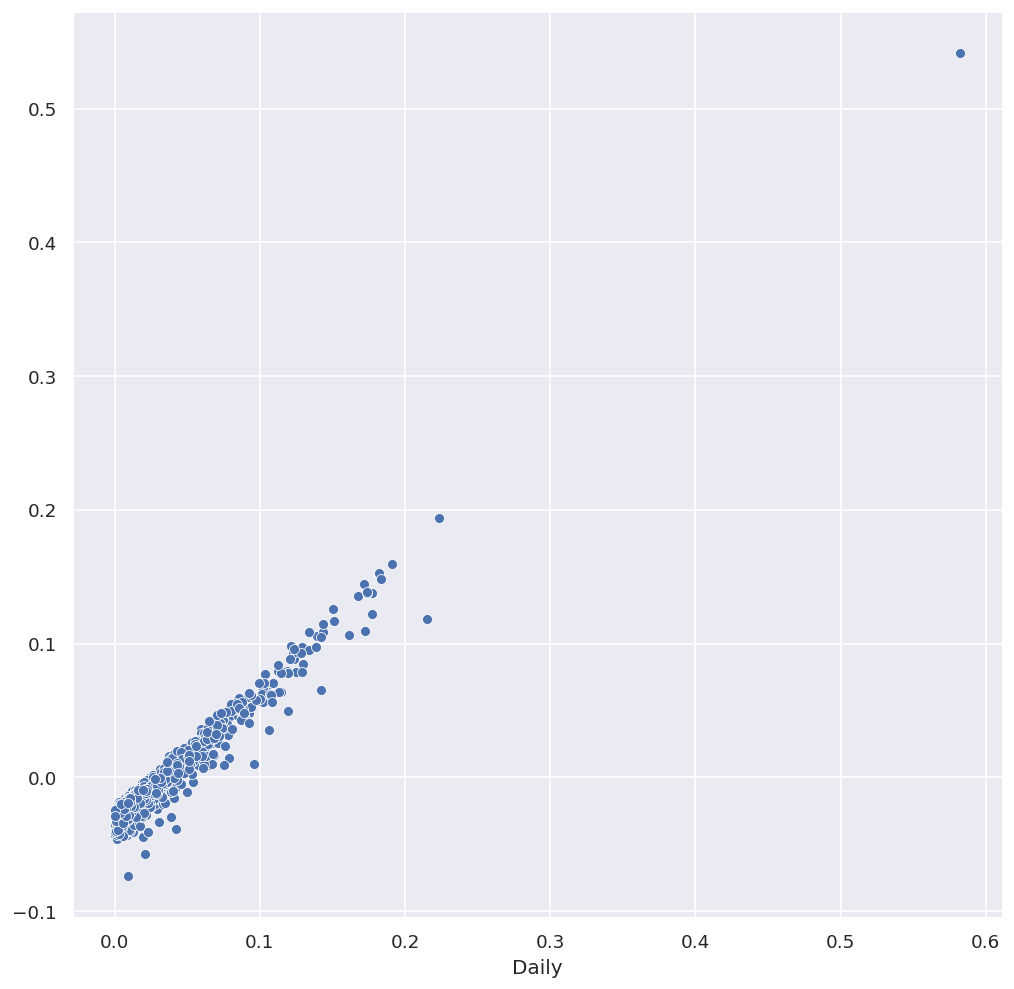

In [92]:
sns.scatterplot(x=y_train, y=results.resid.values)

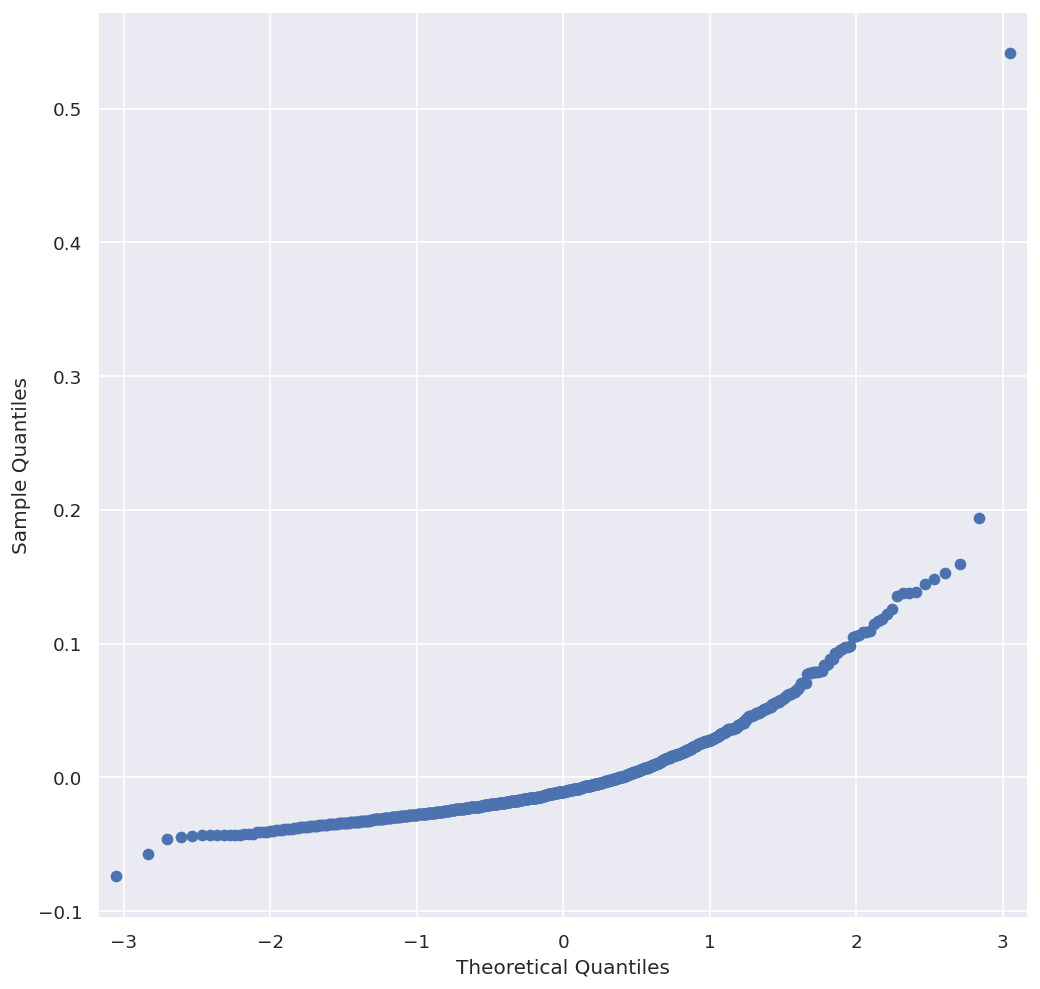

In [93]:
>>> fig = sm.qqplot(results.resid.values)


### HARQ-F

The HARQ is developed to account for the properties of the measurement error in modeling and forecasting volatility.
Exploits the fact that the error in standard realized measures is hetereoskedastic.
On days where the measurement error is small, realized volatility provides a stronger signal for the next day's volatility than on days where it is large.
The HARQ models allow for time-varying autoregressive parameters which are high when variance is low, and adjusted downwared on days when the signal is weak.
These models can be estimated by OLS.
It is shown that the HARQ allows for more persistence in "normal times" and quick mean reversion in erratic times.

The HARQ model is written as:
$$RV_t = \beta_0 + (\beta_1 + \beta_{1Q}RQ_{t-1}^{1/2})RV_{t-1} + \beta_2 RV_{t-1 |t-5} + \beta_3 RV_{t-1|t-22} + u_t$$
where the realized quartercity (RQ) is defined as $RQ_t=\frac{M}{3}\sum_{i=1}^M r^4_{t,i}$.

If we rewrite the HARQ model we are able to estimate the parameters of the model using OLS regression:
$$RV_t = \beta0 + \beta1 RV_{t-1} + \beta_{1Q}RQ^{1/2}_{t-1}RV_{t-1} + \beta_2 RV_{t-1|t-5} 0 \beta_3 RV_{t-1|t-22} + u_t$$

In [84]:
def realized_quarticity(series):
    return np.sum(series**4)*series.shape[0]/3

In [73]:
y = rv_1min['Daily'][1:].reset_index(drop=True)
X = rv_1min.iloc[:-1, :].reset_index(drop=True)


In [74]:
X['RQ1RV1'] = np.sqrt(realized_quarticity(X['Daily'])) * X['Daily']
X['RQ2RV2'] = np.sqrt(realized_quarticity(X['Weekly'])) * X['Weekly']
X['RQ3RV3'] = np.sqrt(realized_quarticity(X['Monthly'])) * X['Monthly']
X = X.reindex(columns=["Daily", "RQ1RV1", "Weekly", "RQ2RV2", "Monthly", "RQ2RV2"])

In [75]:
dates = y.index
X = sm.add_constant(X)

train_test_split = int(0.66 * X.shape[0])

X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]

In [76]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     14.15
Date:                Sun, 08 May 2022   Prob (F-statistic):           5.22e-09
Time:                        16:43:00   Log-Likelihood:                 1600.2
No. Observations:                 878   AIC:                            -3192.
Df Residuals:                     874   BIC:                            -3173.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.004      4.002      0.000       0.008       0.024
Daily          0.0006      0.000      1.302      0.193      -0.000       0.002
RQ1RV1         0.0055      0.004      1.302      0.193      -0.003       0.014
Weekly         0.0286      0.009      3.287      0.001       0.012       0.046
RQ2RV2         0.0635      0.019      3.287      0.001       0.026       0.101
Monthly        0.1779      0.133      1.334      0.182      -0.084       0.440
RQ2RV2         0.0635      0.019      3.287      0.001       0.026       0.101
==============================================================================
Omnibus:                      859.493   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71192.407
Skew:                           4.249   Prob(JB):                         0.00
Kurtosis:                      46.288   Cond. No.                     8.45e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.38e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

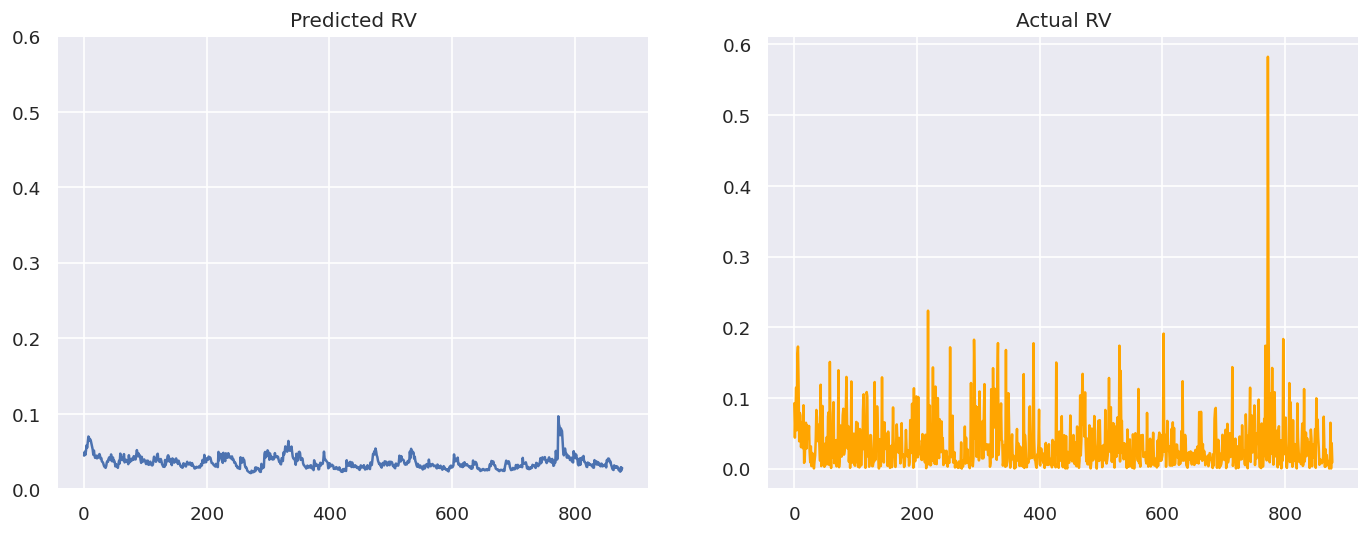

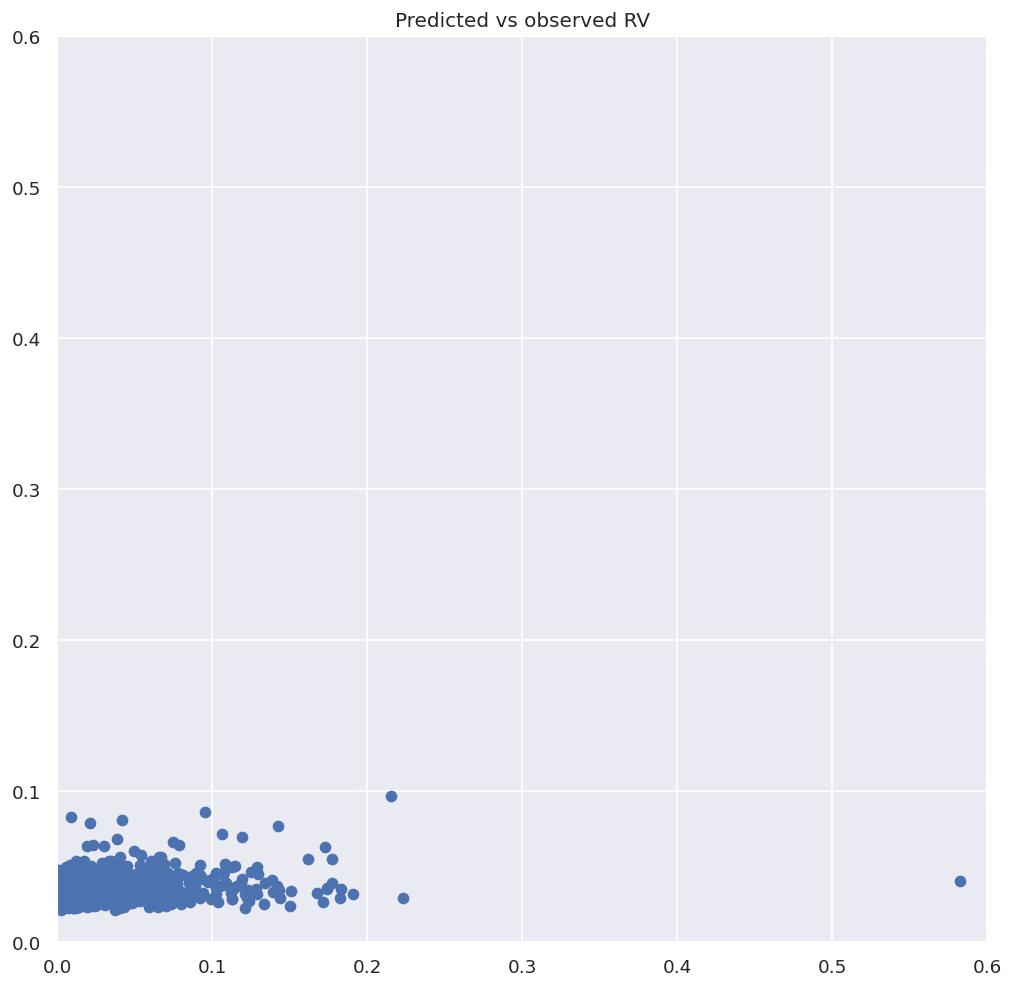

In [77]:

y_hat = results.predict(X_train)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train.index, y_train, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train, y_hat)
plt.title("Predicted vs observed RV")
plt.ylim([0, 0.6])
plt.xlim([0, 0.6])

plt.show()

### HAR-J

The above HAR models does not take jump processes into account.
Therefore, Andersen et al. (2007) developed the HAR-J model denoted as:
$$R_{t+h} = \beta_0 + \beta_d RV_t^{(1)} + \beta_w RV_t^{5} + \beta_m RV_t^{22} + \beta^j J_t + e_{t+h}$$
where the empirical measurement of the squared jumps is $J_t = max(RV_t - BPV_t, 0)$ and the standardized realized bipower variation (BPV) is defined as:
$$BPV_t \equiv (2 / \pi)^{-1} \sum_{j=2}^M |r_{t,j-1}||r_{t,j}|$$

In [63]:
def bipower_variation(series):
    return [(1/(2/np.pi)) * np.sum(np.abs(series[i+1]) - np.abs(series[i])) for i in range(series.shape[0] - 1)]

In [64]:
def squared_jumps(series):
    bpv = bipower_variation(series)
    return [np.max(series[i + 1] - bpv[i], 0) for i in range(len(series) - 1)]

In [65]:
X_harj = rv_1min[1:]
jumps = squared_jumps(X_harj['Daily'])[:-1]
X_harj = X_harj[1:-1]
X_harj["Jumps"] = jumps
X_harj = X_harj.reset_index(drop=True)
X_harj

,Daily,Weekly,Monthly,Jumps
0,0.043813,0.052459,0.060247,0.119986
1,0.079271,0.062001,0.062902,0.023574
2,0.114659,0.078325,0.066273,0.059072
3,0.054186,0.077808,0.066725,0.149176
4,0.161486,0.085718,0.068755,-0.007061
...,...,...,...,...
1324,0.012809,0.038389,0.034280,0.072640
1325,0.048655,0.036050,0.034903,-0.007652
1326,0.010739,0.035036,0.034623,0.070297
1327,0.031773,0.033651,0.035595,-0.001267


In [66]:
y_harj = rv_1min['Daily'][3:].reset_index(drop=True)
y_harj

0       0.079271
1       0.114659
2       0.054186
3       0.161486
4       0.172622
          ...   
1324    0.048655
1325    0.010739
1326    0.031773
1327    0.111541
1328    0.001542
Name: Daily, Length: 1329, dtype: float64

In [67]:
dates = y[1:].index
X_harj = sm.add_constant(X_harj)

train_test_split = int(0.66 * X_harj.shape[0])

X_train_harj, X_test_harj = X_harj[:train_test_split], X_harj[train_test_split:]
y_train_harj, y_test_harj = y_harj[:train_test_split], y_harj[train_test_split:]

In [68]:
X_train_harj

,const,Daily,Weekly,Monthly,Jumps
0,1.0,0.043813,0.052459,0.060247,0.119986
1,1.0,0.079271,0.062001,0.062902,0.023574
2,1.0,0.114659,0.078325,0.066273,0.059072
3,1.0,0.054186,0.077808,0.066725,0.149176
4,1.0,0.161486,0.085718,0.068755,-0.007061
...,...,...,...,...,...
872,1.0,0.004000,0.007827,0.024424,-0.001954
873,1.0,0.064889,0.016595,0.025963,-0.030755
874,1.0,0.000186,0.013877,0.025417,0.101820
875,1.0,0.036102,0.018087,0.025419,-0.020314


In [69]:
y_train_harj

0      0.079271
1      0.114659
2      0.054186
3      0.161486
4      0.172622
         ...   
872    0.064889
873    0.000186
874    0.036102
875    0.008831
876    0.012401
Name: Daily, Length: 877, dtype: float64

In [70]:
results = sm.OLS(y_train_harj, X_train_harj).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     10.79
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.54e-08
Time:                        16:42:54   Log-Likelihood:                 1599.1
No. Observations:                 877   AIC:                            -3188.
Df Residuals:                     872   BIC:                            -3164.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.004      4.056      0.000       0.008       0.024
Daily          0.0291      0.042      0.695      0.487      -0.053       0.111
Weekly         0.3617      0.105      3.459      0.001       0.156       0.567
Monthly        0.1635      0.134      1.221      0.223      -0.099       0.426
Jumps         -0.0256      0.024     -1.053      0.292      -0.073       0.022
==============================================================================
Omnibus:                      856.385   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70180.792
Skew:                           4.235   Prob(JB):                         0.00
Kurtosis:                      45.998   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

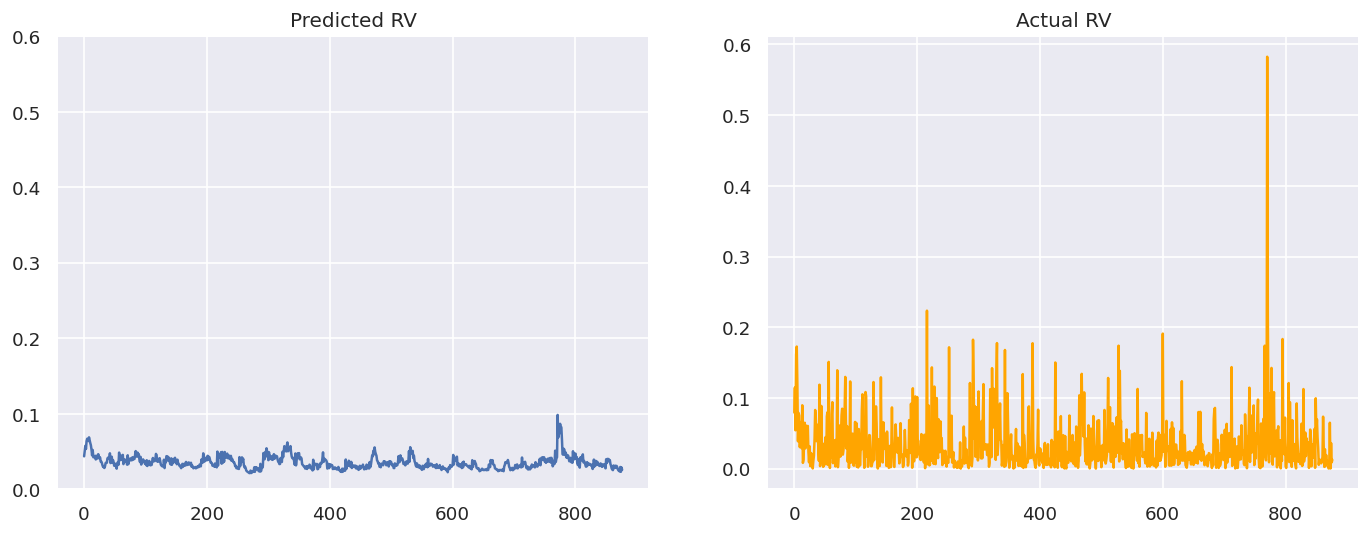

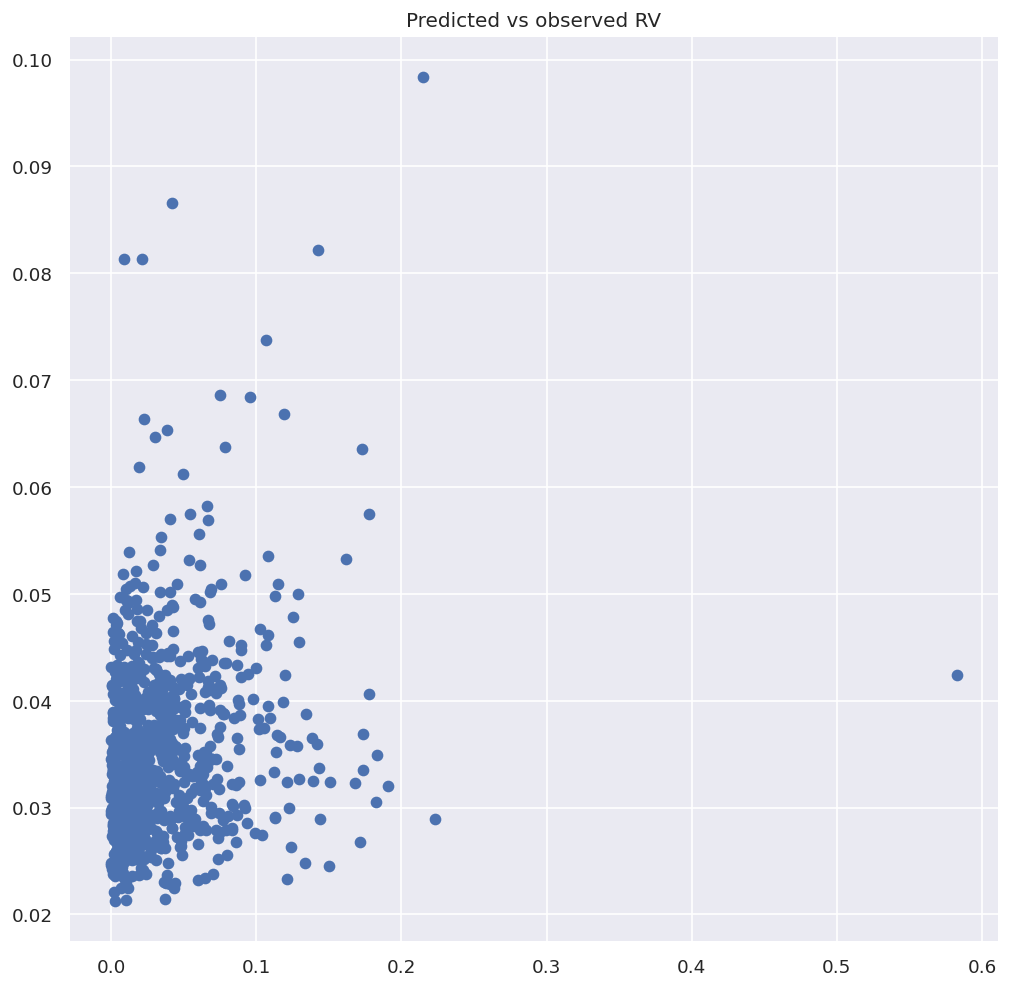

In [71]:
y_hat = results.predict(X_train_harj)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train_harj.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train_harj.index, y_train_harj, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train_harj, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

### HAR-RS-I

To capture the role of the "leverage effect" in predicting volatility dynamics, Patton and Sheppard developed a group of models using signed realized measures.
The HAR-RS-I model decomposes the daily realized volatility in the standard HAR model into two asymmetric semi-variances: $RS^+_t$ and $R^-_t$:
$$RV_{t+h} = \beta_0 + \beta^+_d RS_t^+ \beta_d^RS_t^- + \beta_w RV_t^{(5)}+\beta_m RV_t^{(22)} + e_{t + h}$$
where $RS^-_t = \sum_{j=1}^M r^2_{t,j} * \mathcal{I}(r_{t,j} < 0)$ and $RS^-_t = \sum_{j=1}^M r^2_{t,j} * \mathcal{I}(r_{t,j} > 0)$.

In [37]:
def realized_semi_variance(series, sign: str):
    if sign == "positive":
        value = [1 if series[i] > 0 else 0 for i in range(len(series))]
    else:
        value = [1 if series[i] < 0 else 0 for i in range(len(series))]
    return value

In [38]:
X_harrsi = rv_1min
X_harrsi
X_harrsi = X_harrsi.merge(dataset.returns("Close", "daily"), left_index=True, right_index=True)
X_harrsi['RV+'] = X_harrsi['Daily'] * realized_semi_variance(X_harrsi['Close'], "positive")
X_harrsi['RV-'] = X_harrsi['Daily'] * realized_semi_variance(X_harrsi['Close'], "negative")
X_harrsi = X_harrsi.drop(columns=["Close", "Daily"])
X_harrsi = X_harrsi[:-1].reset_index(drop=True)

In [39]:
X_harrsi

,Weekly,Monthly,RV+,RV-
0,0.046161,0.063110,0.000000,0.054305
1,0.057305,0.061766,0.000000,0.092306
2,0.052459,0.060247,0.043813,0.000000
3,0.062001,0.062902,0.000000,0.079271
4,0.078325,0.066273,0.000000,0.114659
...,...,...,...,...
1326,0.038389,0.034280,0.000000,0.012809
1327,0.036050,0.034903,0.000000,0.048655
1328,0.035036,0.034623,0.010739,0.000000
1329,0.033651,0.035595,0.000000,0.031773


In [40]:
y_harrsi = rv_1min['Daily'][1:].reset_index(drop=True)
y_harrsi

0       0.092306
1       0.043813
2       0.079271
3       0.114659
4       0.054186
          ...   
1326    0.048655
1327    0.010739
1328    0.031773
1329    0.111541
1330    0.001542
Name: Daily, Length: 1331, dtype: float64

In [41]:
dates = y_harrsi[1:].index
X_harrsi = sm.add_constant(X_harrsi)

train_test_split = int(0.66 * X_harrsi.shape[0])

X_train_harrsi, X_test_harrsi = X_harrsi[:train_test_split], X_harrsi[train_test_split:]
y_train_harrsi, y_test_harrsi = y_harrsi[:train_test_split], y_harrsi[train_test_split:]

In [42]:
results = sm.OLS(y_train_harrsi, X_train_harrsi).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     12.24
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.09e-09
Time:                        16:22:18   Log-Likelihood:                 1603.3
No. Observations:                 878   AIC:                            -3197.
Df Residuals:                     873   BIC:                            -3173.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.004      4.065      0.000       0.008       0.024
Weekly         0.3193      0.094      3.385      0.001       0.134       0.504
Monthly        0.1829      0.133      1.376      0.169      -0.078       0.444
RV+           -0.0378      0.051     -0.741      0.459      -0.138       0.062
RV-            0.0899      0.041      2.200      0.028       0.010       0.170
==============================================================================
Omnibus:                      856.494   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70876.584
Skew:                           4.224   Prob(JB):                         0.00
Kurtosis:                      46.198   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

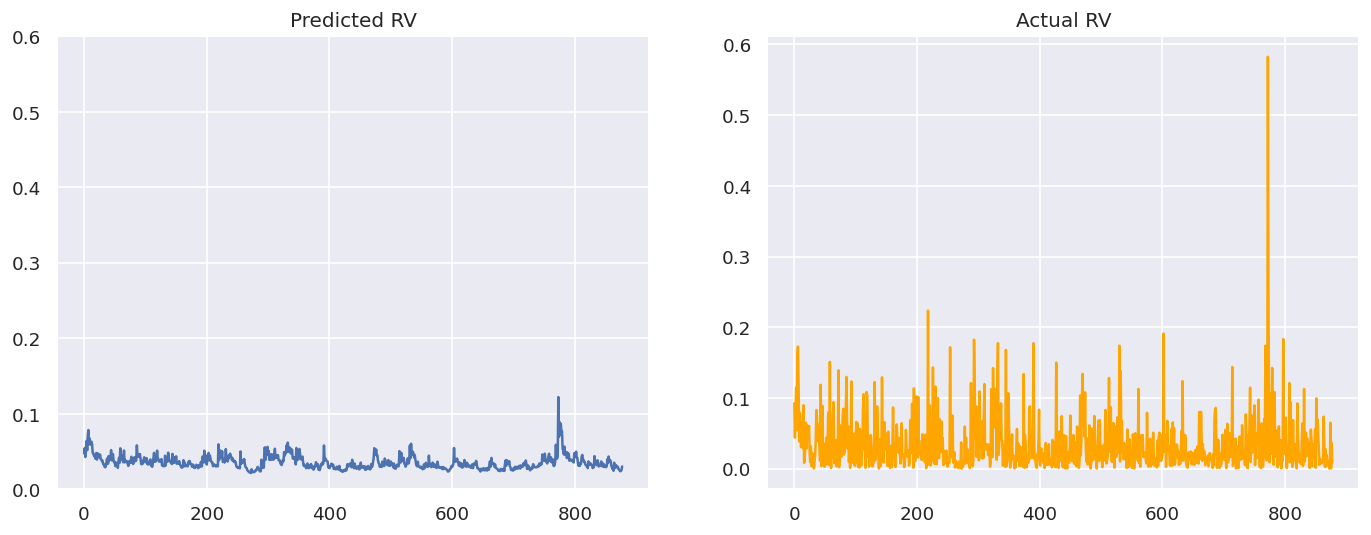

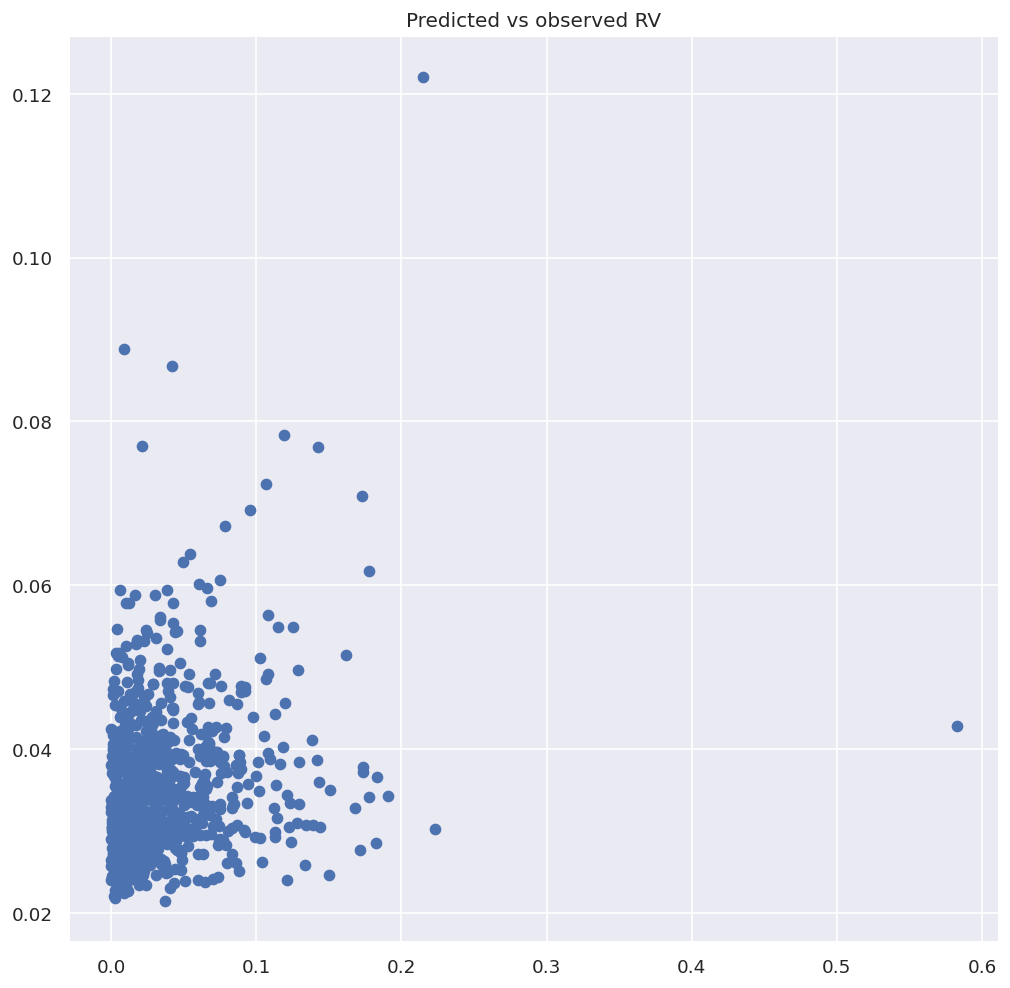

In [45]:
y_hat = results.predict(X_train_harrsi)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train_harrsi.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train_harrsi.index, y_train_harrsi, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train_harrsi, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

### MARS

[Versatile HAR model for realized volatility: A least square
model averaging perspective](https://reader.elsevier.com/reader/sd/pii/S2096232019300046?token=0CCD5C90F3E5F85F534AB8C22C616CCA4CA7405F63A7F603B82831506AD64AD024F6BB5DEC2E090C750D3940EE544A39&originRegion=eu-west-1&originCreation=20220505091619)

### Neural Network Specification of HAR model

A variational autoencoder 

### End-to-End Transformer

## Forecasting Evaluation

In [15]:
def mean_squared_forecast_error(target, predictions):
    pass

In [16]:
def mean_absolute_forecast_error(target, prediction):
    pass

In [ ]:
def mean_squared_deviation_forecase_error(target, prediction):
    pass